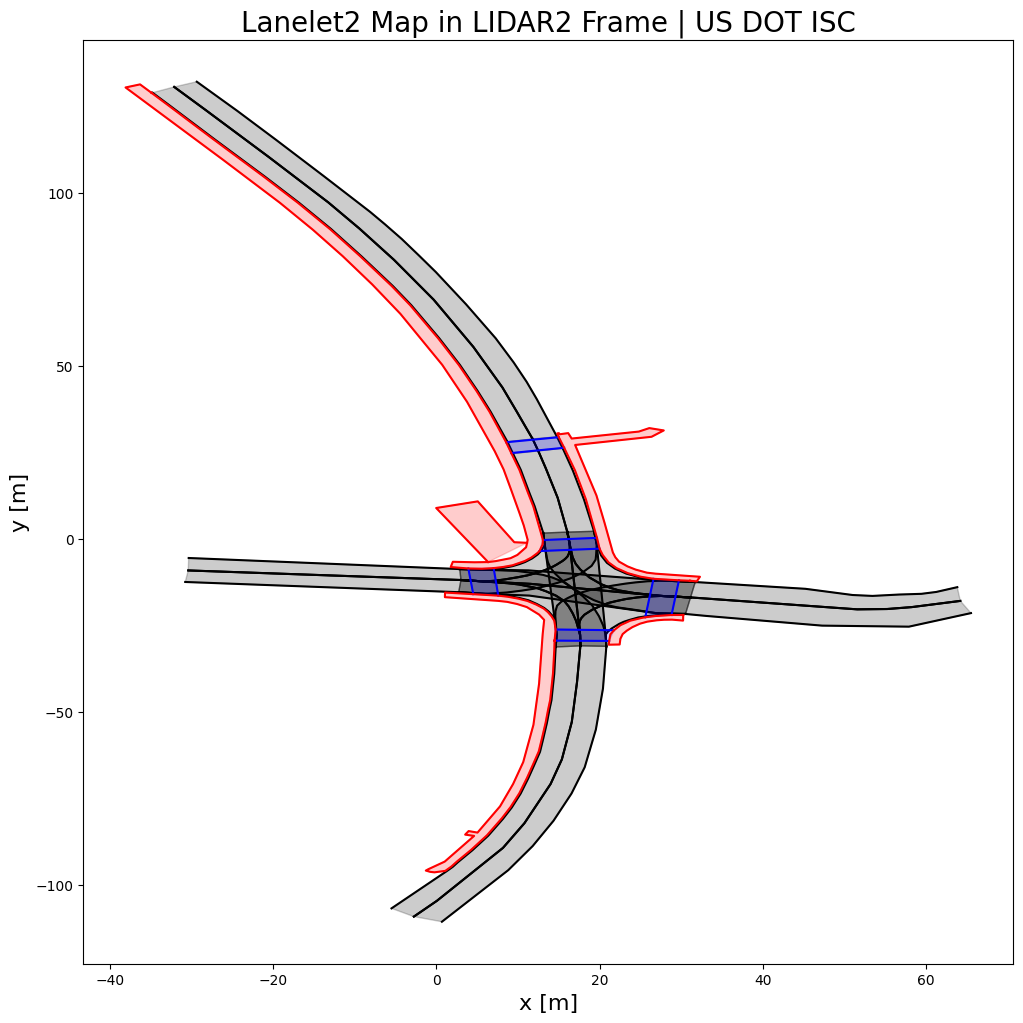

In [3]:
import numpy as np
import lanelet2
import yaml
import math
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image

#######################################################################
# Functions
#######################################################################

def latlon2utm(lat, lon):
    # Constants
    a = 6378137.0  # WGS84 major axis
    f = 1 / 298.257223563  # WGS84 flattening
    k0 = 0.9996  # scale factor

    # Calculate the UTM Zone
    zone_number = int((lon + 180) / 6) + 1
    
    # Calculate central meridian for the zone
    lambda0 = math.radians((zone_number - 1) * 6 - 180 + 3)
    
    # Convert latitude and longitude to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)

    e = math.sqrt(1 - (1 - f) * (1 - f))
    N = a / math.sqrt(1 - e * e * math.sin(lat_rad) * math.sin(lat_rad))
    T = math.tan(lat_rad) * math.tan(lat_rad)
    C = (e * e / (1 - e * e)) * math.cos(lat_rad) * math.cos(lat_rad)
    A = (lon_rad - lambda0) * math.cos(lat_rad)

    M = a * ((1 - e * e / 4 - 3 * e * e * e * e / 64 - 5 * e * e * e * e * e * e / 256) * lat_rad
            - (3 * e * e / 8 + 3 * e * e * e * e / 32 + 45 * e * e * e * e * e * e / 1024) * math.sin(2 * lat_rad)
            + (15 * e * e * e * e / 256 + 45 * e * e * e * e * e * e / 1024) * math.sin(4 * lat_rad)
            - (35 * e * e * e * e * e * e / 3072) * math.sin(6 * lat_rad))

    x = k0 * N * (A + (1 - T + C) * A * A * A / 6
                + (5 - 18 * T + T * T + 72 * C - 58 * e * e / (1 - e * e)) * A * A * A * A * A / 120) + 500000.0

    y = k0 * (M + N * math.tan(lat_rad) * (A * A / 2
                + (5 - T + 9 * C + 4 * C * C) * A * A * A * A / 24
                + (61 - 58 * T + T * T + 600 * C - 330 * e * e / (1 - e * e)) * A * A * A * A * A * A / 720))

    if lat < 0:
        y += 10000000.0  # 10000000 meter offset for southern hemisphere

    return zone_number, x, y


#######################################################################
# Calib Params
#######################################################################

utm_to_l2 = np.array(
    [[-3.33503803e-01, -9.42696322e-01, -9.94269360e-03, 4.17142977e+06],
    [9.42703142e-01,  -3.33572864e-01,  6.31904433e-03, 1.14323155e+06],
    [-9.27355262e-03, -7.26558318e-03,  9.99930604e-01, 3.42488069e+04],
    [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]]
)

l2_to_utm = np.linalg.inv(utm_to_l2)


#######################################################################
# Load lanelet2 map
#######################################################################

fp = '/home/ma/francescopittaluga/usdotisc/lanelet2_map'
osm_path = '{}/lanelet2_map.osm'.format(fp)
config_path = '{}/map_config.yaml'.format(fp)

with open(config_path) as stream:
    config = yaml.full_load(stream)

origin = np.array([config['/**']['ros__parameters']['map_origin']['latitude'],config['/**']['ros__parameters']['map_origin']['longitude']])
origin_utm = np.array(latlon2utm(origin[0],origin[1])[1:])

ll2_api = lanelet2.io.load(osm_path,lanelet2.projection.UtmProjector(lanelet2.io.Origin(origin[0], origin[1])))   


#######################################################################
# Plot lanelet2 map
#######################################################################


fig = plt.figure(figsize=(12,12))

for lane in ll2_api.laneletLayer:
    left_bound_utm = np.array([np.array([point.x, point.y])+origin_utm for point in ll2_api.laneletLayer[lane.id].leftBound])
    right_bound_utm = np.array([np.array([point.x, point.y])+origin_utm for point in ll2_api.laneletLayer[lane.id].rightBound])
    centerline_utm = np.array([np.array([point.x, point.y])+origin_utm for point in ll2_api.laneletLayer[lane.id].centerline])

    left_bound_utm = np.hstack((left_bound_utm, np.zeros_like(left_bound_utm[:,0:1]), np.ones_like(left_bound_utm[:,0:1])))
    right_bound_utm = np.hstack((right_bound_utm, np.zeros_like(right_bound_utm[:,0:1]), np.ones_like(right_bound_utm[:,0:1])))
    centerline_utm = np.hstack((centerline_utm, np.zeros_like(centerline_utm[:,0:1]), np.ones_like(centerline_utm[:,0:1])))

    left_bound_l2 = utm_to_l2.dot(left_bound_utm.T).T
    right_bound_l2 = utm_to_l2.dot(right_bound_utm.T).T
    centerline_l2 = utm_to_l2.dot(centerline_utm.T).T

    polygon_l2 = np.vstack([left_bound_l2,right_bound_l2[::-1]])

    if lane.attributes['subtype'] == 'road':
        plt.plot(left_bound_l2[:,0], left_bound_l2[:,1], color=(0,0,0), zorder=1)
        plt.plot(right_bound_l2[:,0], right_bound_l2[:,1], color=(0,0,0), zorder=1)
        #plt.plot(centerline_l2[:,0], centerline_l2[:,1], color=(0.6,0.6,0.6), zorder=1)
        plt.fill(polygon_l2[:,0], polygon_l2[:,1], color=(0,0,0), alpha=0.2, zorder=1)
    else:
        plt.plot(left_bound_l2[:,0], left_bound_l2[:,1], color=(0,0,1), zorder=2)
        plt.plot(right_bound_l2[:,0], right_bound_l2[:,1], color=(0,0,1), zorder=2)
        plt.fill(polygon_l2[:,0], polygon_l2[:,1], color=(0,0,1), alpha=0.2, zorder=2)


for way in ll2_api.lineStringLayer:
    
    if ll2_api.lineStringLayer[way.id].attributes['type'] == 'curbstone':
        
        way_utm = np.array([np.array([point.x, point.y])+origin_utm for point in ll2_api.lineStringLayer[way.id]])
        way_utm = np.hstack((way_utm, np.zeros_like(way_utm[:,0:1]), np.ones_like(way_utm[:,0:1])))
        
        way_l2 = utm_to_l2.dot(way_utm.T).T

        plt.plot(way_l2[:,0], way_l2[:,1], color=(1,0,0), zorder=2)
        plt.fill(way_l2[:,0], way_l2[:,1], color=(1,0,0), alpha=0.2, zorder=2)


    

plt.title('Lanelet2 Map in LIDAR2 Frame | US DOT ISC', fontsize=20)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.show()